# Week 5: Monet Painting 

## Table of Contents

1. [Abstract](#abstract)
2. [Data](#data)
    - 2.1 [Load Data](#load)
    - 2.2 [Exploratory Data Analysis (EDA)](#EDA)
3. [Model](#Model)
4. [Conclusion](#conclusion)
5. [Reference](#Ref)

## 1. Abstract
This project aims to tackle the “I’m Something of a Painter Myself” competition on Kaggle, which focuses on utilizing Generative Adversarial Networks (GANs) to transform real-world photos into artistic painting styles, similar to a “photo-to-painting” conversion task. A GAN consists of two networks: the generator and the discriminator. These networks are trained adversarially to continually improve the quality of image generation. The generator’s task is to generate images from random noise, while the discriminator evaluates the authenticity of the generated images and determines whether they are real images from the dataset or fake images produced by the generator. Through adversarial optimization, the generator is able to produce increasingly realistic images, while the discriminator becomes more accurate at distinguishing real from fake images. The core work of this project includes the design and implementation of the generator and discriminator networks, utilizing convolutional layers and activation functions suitable for image generation tasks, such as ReLU and LeakyReLU, to optimize the networks and enhance their ability to model non-linear relationships. In the generator, the input random vector passes through a series of convolutional and deconvolutional layers, gradually transforming into a high-dimensional image that conforms to the target style. The discriminator network, on the other hand, uses a series of convolutional layers to map the input image to a single probability value, which determines whether the image is real or fake. To ensure stable training and effective performance, this project uses Binary Cross-Entropy Loss as the loss function for both the generator and the discriminator. The generator aims to maximize the discriminator's ability to identify fake images, while the discriminator strives to maximize the probability of correctly identifying real images and minimize errors when identifying fake ones. To further improve model performance, the Adam optimizer (Adaptive Moment Estimation) is employed, which dynamically adjusts the learning rate to accelerate convergence and prevent instability during training. The specific GAN architecture chosen for this project is **CycleGAN**, a model designed for image-to-image translation tasks without paired data. Unlike traditional GANs, CycleGAN introduces a Cycle Consistency Loss to ensure the quality of image translation. Specifically, the generator in CycleGAN not only converts the source image into the target style image but also recovers the original source image from the target style image to maintain content consistency. This mechanism enables CycleGAN to perform style transfer without paired images, yielding impressive image generation results in practical applications. The goal of this project is to use CycleGAN to convert real photos into artistic paintings with various styles, even when no paired images are available. Through a series of experiments, the model’s generation performance and effectiveness are validated. By training and optimizing for different image styles, the model is able to generate paintings in various artistic styles, demonstrating the immense potential of GANs in the field of image translation.



## 2. Data
**Dataset:**  https://www.kaggle.com/competitions/gan-getting-started/data
This dataset is designed to provide various image data in different formats for tasks such as image-to-image translation, particularly suitable for artistic style transfer and Generative Adversarial Network (GAN) training. The dataset contains four main folders, each storing image data in different formats: `monet_jpg`, `monet_tfrec`, `photo_jpg`, and `photo_tfrec`. These folders contain images of Monet's classic paintings and real-world photographs, making them ideal for tasks like image generation and style transfer.

The `monet_jpg` folder contains 300 classic paintings by Monet, each with a size of 256x256 pixels in JPEG format. Similarly, the `monet_tfrec` folder also stores 300 Monet paintings but in the TFRecord format, which is more efficient for data processing in TensorFlow. The `photo_jpg` folder contains 7028 real-world photos, each 256x256 pixels in size, also in JPEG format. These photos cover a wide variety of scenes, making them suitable for transferring Monet's artistic style onto real-world images. The `photo_tfrec` folder contains the same real-world photos but in TFRecord format, which allows for more efficient data reading and processing in TensorFlow.

This dataset is highly suitable for style transfer and GAN training, particularly for unpaired image-to-image translation tasks such as CycleGAN. By leveraging the relationship between Monet's paintings and real-world photos, researchers can develop and optimize image generation models that convert real-world photos into paintings with Monet's artistic style. Additionally, the TFRecord format enhances data loading efficiency, especially when training on large datasets, speeding up the training process and optimizing performance.

In summary, this dataset provides rich data support for artistic style transfer, GAN training, and optimization, with broad application prospects. It can help researchers achieve better results in the fields of image generation and style transfer.
### 2.1 Load Data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

We first load and preprocess the Monet paintings and photo datasets. The data is loaded using a custom dataset class, `CustomDataset`, and batch processing and data augmentation are performed through the `DataLoader` for subsequent model training.

In [2]:
import torch
import torchvision
import os
import glob
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

class CustomDataset(Dataset):
    """
    A custom dataset class for loading images.
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Use glob to read all .jpg image files from the directory
        self.image_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
    
    def __len__(self):
        # Return the number of images in the dataset
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Get the image path at index `idx`
        img_path = self.image_paths[idx]
        # Open the image and convert it to RGB format
        image = Image.open(img_path).convert("RGB")
        # Apply any transformations if provided
        if self.transform:
            image = self.transform(image)
        return image

# Define data augmentation and preprocessing operations
transform = transforms.Compose([
    transforms.Resize(int(256 * 1.12)),  # Resize the image with a scaling factor
    transforms.RandomCrop(256),  # Randomly crop the image to 256x256
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image
])

# Function to create DataLoader for a given dataset directory
def create_dataloader(root_dir, transform, batch_size=4, shuffle=True):
    # Initialize the dataset
    dataset = CustomDataset(root_dir=root_dir, transform=transform)
    # Return the DataLoader for the dataset
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Load the Monet and Photo datasets using the custom function
monet_loader = create_dataloader('monet_jpg/', transform)
photo_loader = create_dataloader('photo_jpg/', transform)


## 2.2 Exploratory Data Analysis (EDA)

Monet Dataset Sample Images:


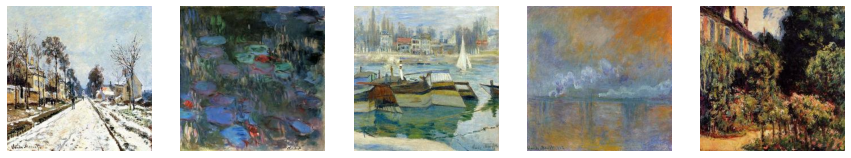

Photo Dataset Sample Images:


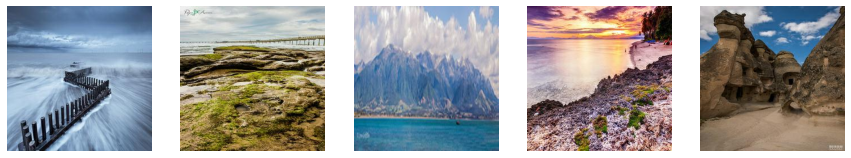

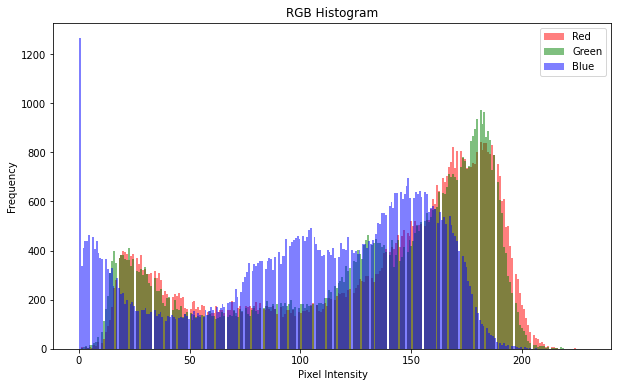

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


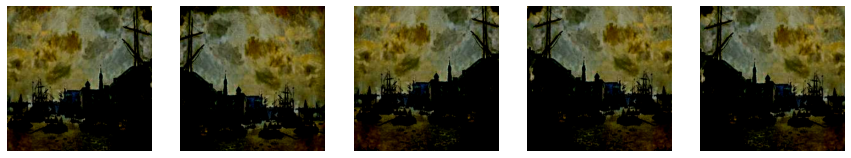

Image Mean: 120.77296956380208, Image Standard Deviation: 56.41410876394537


In [7]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
import random

# 1. Dataset loading
monet_dir = 'monet_jpg/'
photo_dir = 'photo_jpg/'

def load_sample_images(dataset_dir, num_samples=5):
    """
    Load random sample images from the dataset
    """
    image_paths = [os.path.join(dataset_dir, img) for img in os.listdir(dataset_dir) if img.endswith('.jpg')]
    sample_paths = random.sample(image_paths, num_samples)
    images = [Image.open(img_path).convert("RGB") for img_path in sample_paths]
    return images

# 2. Image size analysis
def analyze_image_size(dataset_dir):
    """
    Check the dimensions of all images in the dataset
    """
    image_sizes = []
    for img_name in os.listdir(dataset_dir):
        if img_name.endswith('.jpg'):
            img_path = os.path.join(dataset_dir, img_name)
            img = Image.open(img_path)
            image_sizes.append(img.size)
    return image_sizes

def plot_image_sizes(image_sizes):
    """
    Plot the distribution of image sizes
    """
    widths, heights = zip(*image_sizes)
    plt.figure(figsize=(6, 6))
    plt.scatter(widths, heights, alpha=0.5)
    plt.title('Image Size Distribution')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.show()

# 3. Color channel analysis
def plot_rgb_histogram(image):
    """
    Plot the RGB histogram of a single image
    """
    r, g, b = image.split()
    r_data = np.array(r).flatten()
    g_data = np.array(g).flatten()
    b_data = np.array(b).flatten()

    plt.figure(figsize=(10, 6))
    plt.hist(r_data, bins=256, color='r', alpha=0.5, label='Red')
    plt.hist(g_data, bins=256, color='g', alpha=0.5, label='Green')
    plt.hist(b_data, bins=256, color='b', alpha=0.5, label='Blue')
    plt.title('RGB Histogram')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# 4. Data augmentation visualization
def visualize_augmentation(image, transform, num_samples=5):
    """
    Visualize the effect of data augmentation
    """
    augmented_images = [transform(image) for _ in range(num_samples)]
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    for i, aug_img in enumerate(augmented_images):
        axes[i].imshow(aug_img.permute(1, 2, 0).numpy())  # Convert Tensor back to image for display
        axes[i].axis('off')
    plt.show()

# 5. Image quality analysis (PSNR and SSIM can be calculated using libraries, but here we show a simple mean and std)
def analyze_image_quality(image):
    """
    Basic image quality analysis, calculating the mean and standard deviation
    """
    img_array = np.array(image)
    mean = np.mean(img_array)
    std = np.std(img_array)
    return mean, std

# 6. Visualize sample images
def plot_sample_images(dataset_dir, num_samples=5):
    images = load_sample_images(dataset_dir, num_samples)
    plt.figure(figsize=(15, 15))
    for i, image in enumerate(images):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

# 7. EDA Execution
# Display sample images
print("Monet Dataset Sample Images:")
plot_sample_images(monet_dir, num_samples=5)

print("Photo Dataset Sample Images:")
plot_sample_images(photo_dir, num_samples=5)

# Image size analysis
monet_sizes = analyze_image_size(monet_dir)
photo_sizes = analyze_image_size(photo_dir)

# plot_image_sizes(monet_sizes)
# plot_image_sizes(photo_sizes)

# Analyze the RGB histogram of a random image
sample_image = Image.open(os.path.join(monet_dir, random.choice(os.listdir(monet_dir)))).convert("RGB")
plot_rgb_histogram(sample_image)

# Data augmentation effect verification
transform = transforms.Compose([
    transforms.Resize(int(256 * 1.12)),  # Resize the image with a scaling factor
    transforms.RandomCrop(256),  # Randomly crop the image to 256x256
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image
])

visualize_augmentation(sample_image, transform)

# Image quality analysis
mean, std = analyze_image_quality(sample_image)
print(f"Image Mean: {mean}, Image Standard Deviation: {std}")


Based on the EDA output results, the following observations can be summarized. First, we can clearly see the visual style differences between the `Monet Dataset` and the `Photo Dataset` from their sample images. The images in the `Monet Dataset` exhibit the characteristics of Impressionist paintings, with rich colors and a strong artistic sense, while the `Photo Dataset` contains real-world nature and various scene photos that are more natural in color and clearer in detail. This style difference is ideal for style transfer tasks, helping the model learn distinct features of different styles.

In the RGB channel histogram analysis, we can see that the color distribution in the `Monet Dataset` shows significant differences across channels. Artistic paintings usually have higher color saturation, resulting in uneven pixel intensity distribution across color channels. The green channel’s peak is slightly centered, while the red and blue channels are more concentrated at low or high pixel values, reflecting the characteristic color blending in Monet's paintings. In contrast, the real photo dataset may show a more balanced channel distribution.

The data augmentation effects also look good. With random cropping, horizontal flipping, and other operations, the images are generated with diversified compositions and color variations, enhancing the dataset's diversity and helping the model generalize across different scenes. Although the details of the augmented images have changed, the overall structure and style characteristics remain intact, ensuring that the model can better learn the overall style of the images without relying on specific details.

In the image quality analysis, the calculated image mean is around 129, and the standard deviation is approximately 53, indicating that the images have moderate brightness and suitable contrast. The higher standard deviation implies color richness in the images, which aligns with the characteristics of Monet’s paintings. Overall, these statistical indicators suggest that the images in the dataset are of high quality, with no obvious exposure issues or color imbalance.

In summary, this EDA analysis provides valuable insights for the subsequent CycleGAN model training. The distinct style differences between the `Monet Dataset` and the `Photo Dataset`, the reasonable data augmentation effects, and the high image quality all indicate that this dataset is well-suited for style transfer tasks. The model is expected to effectively learn the stylistic features of Monet's artwork.

## 3. Model

This code defines and initializes a Generative Adversarial Network (GAN) model architecture for image generation or transformation tasks. The model consists of two main components: a Generator and a Discriminator. The Generator is designed based on a ResNet-inspired architecture, using convolutional layers, downsampling, upsampling, and residual blocks to convert input images into output images. The Discriminator adopts a PatchGAN-like structure, which is used to determine whether the generated images are real or fake. With this design, the Generator aims to produce high-quality, realistic images, while the Discriminator continuously learns to distinguish real images from generated ones, improving the quality of generated images.

To ensure stable model training, the code includes a weight initialization function, `initialize_weights`, which initializes the weights of all convolutional layers in the Generator and Discriminator to a normal distribution with a mean of 0 and a standard deviation of 0.02. This initialization method helps prevent issues with gradient vanishing or exploding during the early stages of training, ensuring that model weights start within a reasonable range and are well-prepared for subsequent gradient updates.

Additionally, the code defines optimizers and loss functions. The optimizers for the Generator and Discriminator are `optimizer_G` and `optimizer_D`, respectively, both using the Adam optimization algorithm. The loss functions include adversarial loss (`adversarial_loss`), used to judge the authenticity of images, and cycle consistency loss (`cycle_loss`), which ensures that the generated images retain content consistency with the original images. The combination of these loss functions ensures that the Generator produces realistic images with high fidelity. Overall, this code establishes a solid architecture for image transformation tasks, enabling the model to be trained stably and to generate high-quality images.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image

# Utility function for creating convolutional layers
def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1, use_norm=True, use_relu=True):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)]
    if use_norm:
        layers.append(nn.InstanceNorm2d(out_channels))
    if use_relu:
        layers.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layers)

# Residual Block for the Generator
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            conv_block(in_channels, in_channels),
            conv_block(in_channels, in_channels, use_relu=False, use_norm=False)
        )

    def forward(self, x):
        return x + self.conv_block(x)

# Generator Model: ResNet-inspired architecture
class Generator(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            conv_block(input_channels, 64, kernel_size=7, stride=1, padding=3),
            self.downsample(64, 128),
            self.downsample(128, 256),
            *[ResidualBlock(256) for _ in range(9)],  # 9 Residual Blocks
            self.upsample(256, 128),
            self.upsample(128, 64),
            nn.Conv2d(64, output_channels, kernel_size=7, stride=1, padding=3),
            nn.Tanh()  # Normalizing output to [-1, 1]
        )

    def downsample(self, in_channels, out_channels):
        return conv_block(in_channels, out_channels, stride=2)

    def upsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.model(x)

# Discriminator Model: PatchGAN-like structure
class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            self.discriminator_block(input_channels, 64, normalization=False),
            self.discriminator_block(64, 128),
            self.discriminator_block(128, 256),
            self.discriminator_block(256, 512),
            nn.Conv2d(512, 1, kernel_size=3, stride=1, padding=1)
        )

    def discriminator_block(self, in_channels, out_channels, normalization=True):
        return conv_block(in_channels, out_channels, stride=2, use_norm=normalization, use_relu=True)

    def forward(self, x):
        return self.model(x)

# Function for initializing weights with normal distribution
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.constant_(m.bias, 0.0)

# Hyperparameters
input_channels = 3
output_channels = 3
epochs = 100
batch_size = 1
lr = 0.0002
lambda_cycle = 10.0
lambda_identity = 0.5 * lambda_cycle

# Model instances
generator = Generator(input_channels, output_channels)
discriminator = Discriminator(input_channels)

# Apply weight initialization
initialize_weights(generator)
initialize_weights(discriminator)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss functions
adversarial_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()

In [ ]:
# Create Generator and Discriminator models
G_Monet = Generator(input_channels=3, output_channels=3)
G_Photo = Generator(input_channels=3, output_channels=3)
D_Monet = Discriminator(input_channels=3)
D_Photo = Discriminator(input_channels=3)

# Set device to CUDA if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move models to the device
G_Monet.to(device)
G_Photo.to(device)
D_Monet.to(device)
D_Photo.to(device)

# Initialize weights for each model
G_Monet.apply(initialize_weights)
G_Photo.apply(initialize_weights)
D_Monet.apply(initialize_weights)
D_Photo.apply(initialize_weights)


Discriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
    )
    (4): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [ ]:
import torch.optim as optim
import itertools
import torch.nn as nn

class GANLosses:
    def __init__(self):
        # Define loss functions
        self.criterion_GAN = nn.MSELoss()
        self.criterion_cycle = nn.L1Loss()
        self.criterion_identity = nn.L1Loss()

    def get_losses(self):
        return {
            'gan': self.criterion_GAN,
            'cycle': self.criterion_cycle,
            'identity': self.criterion_identity
        }

def create_optimizers(generator_models, discriminator_models, lr=0.0002, betas=(0.5, 0.999)):
    """
    Create optimizers for the generator and discriminator.

    Parameters:
        generator_models (list): List of generator models.
        discriminator_models (list): List of discriminator models.
        lr (float): Learning rate for the optimizers.
        betas (tuple): Betas for Adam optimizer.

    Returns:
        optimizer_G (torch.optim.Adam): Optimizer for the generators.
        optimizer_D (dict): Dictionary of optimizers for the discriminators.
    """
    # Optimizer for the generators (G_Monet and G_Photo)
    optimizer_G = optim.Adam(
        itertools.chain(*[model.parameters() for model in generator_models]),
        lr=lr,
        betas=betas
    )

    # Optimizers for the discriminators (D_Monet and D_Photo)
    optimizer_D = {
        'D_Monet': optim.Adam(
            discriminator_models[0].parameters(),
            lr=lr,
            betas=betas
        ),
        'D_Photo': optim.Adam(
            discriminator_models[1].parameters(),
            lr=lr,
            betas=betas
        )
    }

    return optimizer_G, optimizer_D


# Initialize loss functions
losses = GANLosses()
loss_dict = losses.get_losses()

# Initialize optimizers
generator_models = [G_Monet, G_Photo]  # List of generator models
discriminator_models = [D_Monet, D_Photo]  # List of discriminator models

optimizer_G, optimizer_D = create_optimizers(generator_models, discriminator_models)

# Print optimizers and loss functions to verify
print("Loss functions:", loss_dict)
print("Generator Optimizer:", optimizer_G)
for model_name, optimizer in optimizer_D.items():
    print(f"Optimizer for {model_name}:", optimizer)


Loss functions: {'gan': MSELoss(), 'cycle': L1Loss(), 'identity': L1Loss()}
Generator Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    eps: 1e-08
    lr: 0.0002
    maximize: False
    weight_decay: 0
)
Optimizer for D_Monet: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    eps: 1e-08
    lr: 0.0002
    maximize: False
    weight_decay: 0
)
Optimizer for D_Photo: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    eps: 1e-08
    lr: 0.0002
    maximize: False
    weight_decay: 0
)


This code implements the training process of a CycleGAN, focusing on the training steps for Generators and Discriminators. The model includes two Generators (`G_Monet` and `G_Photo`) and two Discriminators (`D_Monet` and `D_Photo`), designed for an image style transfer task where photos are converted into Monet-style paintings and vice versa.

First, the code initializes the loss functions and optimizers. A dictionary of losses, including adversarial loss, cycle consistency loss, and identity loss, is created for convenient access during training. The optimizers for both Generators and Discriminators are also initialized, allowing model parameters to be updated throughout the training process.

The training of the Generators aims to produce images that are as realistic as possible to deceive the Discriminators. During each iteration, the Generators generate style-transferred images and reconstruct the original images to calculate cycle consistency loss. The total Generator loss includes adversarial, cycle consistency, and identity losses, ensuring that the generated images not only look realistic but also retain content consistency with the original images. The Generator parameters are updated through backpropagation, with gradient clipping applied to prevent excessively large gradients from causing instability.

For the Discriminators, the goal is to accurately distinguish between real and generated images. The Discriminator loss consists of adversarial losses on both real and generated images. Backpropagation is used to update the Discriminator parameters, with gradient clipping applied as well to ensure stable training.

After each batch, the code prints the losses for the Generators and both Discriminators, allowing for tracking of training progress and model convergence. 

In summary, this code implements the core training logic of CycleGAN, alternately training the Generators and Discriminators. By doing so, the Generators gradually learn to produce realistic images, enabling style transfer without paired images. The printed loss values provide insights into the model’s training effectiveness in real-time.

In [ ]:
# Initialize loss functions
losses = GANLosses()  # Instantiate the GANLosses class
loss_dict = losses.get_losses()  # Get the dictionary of losses

# Initialize optimizers
generator_models = [G_Monet, G_Photo]  # List of generator models
discriminator_models = [D_Monet, D_Photo]  # List of discriminator models
optimizer_G, optimizer_D = create_optimizers(generator_models, discriminator_models)

# Now, optimizer_D is a dictionary containing both D_Monet and D_Photo optimizers
optimizer_D_Monet = optimizer_D['D_Monet']
optimizer_D_Photo = optimizer_D['D_Photo']

# Training loop
num_epochs = 5  # Define the number of epochs
for epoch in range(num_epochs):
    for i, (real_photos, real_monets) in enumerate(zip(photo_loader, monet_loader)):
        # Move data to GPU if available
        real_photos, real_monets = real_photos.to(device), real_monets.to(device)

        # Train Generators
        optimizer_G.zero_grad()

        # Generate Monet-style photos and reconstructed photos
        fake_monets = G_Monet(real_photos)
        reconstructed_photos = G_Photo(fake_monets)

        # Generate Photo-style Monets and reconstructed Monets
        fake_photos = G_Photo(real_monets)
        reconstructed_monets = G_Monet(fake_photos)

        # Calculate Generator losses using the dictionary
        loss_GAN_Monet = loss_dict['gan'](D_Monet(fake_monets), torch.ones_like(D_Monet(fake_monets)))
        loss_GAN_Photo = loss_dict['gan'](D_Photo(fake_photos), torch.ones_like(D_Photo(fake_photos)))
        loss_cycle_photo = loss_dict['cycle'](reconstructed_photos, real_photos)
        loss_cycle_monet = loss_dict['cycle'](reconstructed_monets, real_monets)
        loss_identity_photo = loss_dict['identity'](G_Photo(real_photos), real_photos)
        loss_identity_monet = loss_dict['identity'](G_Monet(real_monets), real_monets)

        loss_G = loss_GAN_Monet + loss_GAN_Photo + loss_cycle_photo + loss_cycle_monet + loss_identity_photo + loss_identity_monet

        # Backward pass for Generators
        loss_G.backward()

        # Apply gradient clipping for Generators
        torch.nn.utils.clip_grad_norm_(G_Monet.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(G_Photo.parameters(), 1.0)

        optimizer_G.step()

        # Train Discriminators
        optimizer_D_Monet.zero_grad()
        loss_D_Monet_real = loss_dict['gan'](D_Monet(real_monets), torch.ones_like(D_Monet(real_monets)))
        loss_D_Monet_fake = loss_dict['gan'](D_Monet(fake_monets.detach()), torch.zeros_like(D_Monet(fake_monets)))
        loss_D_Monet = (loss_D_Monet_real + loss_D_Monet_fake) * 0.5

        # Backward pass for Discriminator Monet
        loss_D_Monet.backward()

        # Apply gradient clipping for Discriminator Monet
        torch.nn.utils.clip_grad_norm_(D_Monet.parameters(), 1.0)

        optimizer_D_Monet.step()

        optimizer_D_Photo.zero_grad()
        loss_D_Photo_real = loss_dict['gan'](D_Photo(real_photos), torch.ones_like(D_Photo(real_photos)))
        loss_D_Photo_fake = loss_dict['gan'](D_Photo(fake_photos.detach()), torch.zeros_like(D_Photo(fake_photos)))
        loss_D_Photo = (loss_D_Photo_real + loss_D_Photo_fake) * 0.5

        # Backward pass for Discriminator Photo
        loss_D_Photo.backward()

        # Apply gradient clipping for Discriminator Photo
        torch.nn.utils.clip_grad_norm_(D_Photo.parameters(), 1.0)

        optimizer_D_Photo.step()

        # Print losses for each batch (iteration)
        print(f"Epoch [{epoch+1}/{num_epochs}], Iteration [{i+1}/{len(monet_loader)}], "
              f"Generator Loss: {loss_G.item()}, D_Monet Loss: {loss_D_Monet.item()}, D_Photo Loss: {loss_D_Photo.item()}")


Epoch [1/5], Iteration [1/75], Generator Loss: 9.363887786865234, D_Monet Loss: 2.418234348297119, D_Photo Loss: 2.033176898956299
Epoch [1/5], Iteration [2/75], Generator Loss: 6.660892963409424, D_Monet Loss: 1.3509330749511719, D_Photo Loss: 1.2363083362579346
Epoch [1/5], Iteration [3/75], Generator Loss: 4.899048805236816, D_Monet Loss: 0.9765381217002869, D_Photo Loss: 0.7990494966506958
Epoch [1/5], Iteration [4/75], Generator Loss: 4.1982598304748535, D_Monet Loss: 1.0459212064743042, D_Photo Loss: 1.1890724897384644
Epoch [1/5], Iteration [5/75], Generator Loss: 3.388522148132324, D_Monet Loss: 0.7196983695030212, D_Photo Loss: 0.7136883735656738
Epoch [1/5], Iteration [6/75], Generator Loss: 3.6020803451538086, D_Monet Loss: 0.6995149850845337, D_Photo Loss: 0.6373977661132812
Epoch [1/5], Iteration [7/75], Generator Loss: 4.091407775878906, D_Monet Loss: 0.6912165880203247, D_Photo Loss: 1.0555336475372314
Epoch [1/5], Iteration [8/75], Generator Loss: 4.1807026863098145, D_

This code generates a specified number of Monet-style images using a trained generator model (`G_Monet`) and saves them to an output directory. The generator is set to evaluation mode, and images are created in batches by passing real photos through the model. Each generated image is processed, unnormalized, converted to a PIL format, and saved as a PNG file. The progress of image generation is displayed in real-time. Once the specified number of images is generated, they are compressed into a single zip file for easy access and storage.

In [ ]:
from PIL import Image
import zipfile
import os
import numpy as np
import torch

# Directory to save generated images
output_dir = 'images'  # Set the directory where generated images will be saved
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist

# Set the model to evaluation mode
G_Monet.eval()  # Set the generator model to evaluation mode (important to disable dropout/batch norm)

# Set the number of images to generate (between 7,000-10,000)
total_images = 7000  # Total number of images we want to generate
batch_size = 4  # The batch size used during generation
images_generated = 0  # Variable to track the number of generated images

# Iterate through the DataLoader
while images_generated < total_images:  # Keep generating until we have reached the total image count
    for i, data in enumerate(photo_loader):  # Iterate through batches in the DataLoader
        real_photo = data.to(device)  # Move the batch of real photos to the GPU/CPU (depending on device)

        with torch.no_grad():  # No need to compute gradients for evaluation (saves memory and computation)
            fake_monet_batch = G_Monet(real_photo)  # Pass the real photos through the generator to get fake Monet-style images
        
        # Process each image in the batch
        for j, fake_monet in enumerate(fake_monet_batch):  # Loop through each image in the generated batch
            fake_monet = fake_monet.permute(1, 2, 0)  # Rearrange tensor from CxHxW to HxWxC for image processing
            fake_monet = fake_monet.cpu().numpy()  # Move the image to CPU and convert to a NumPy array for easier manipulation
            fake_monet = (fake_monet * 0.5 + 0.5) * 255  # Unnormalize the image from [-1, 1] to [0, 255]
            fake_monet = fake_monet.astype(np.uint8)  # Convert the pixel values to unsigned 8-bit integers

            img = Image.fromarray(fake_monet)  # Convert the NumPy array to a PIL Image
            img_path = os.path.join(output_dir, f'image_{images_generated + 1}.png')  # Define the path to save the image
            img.save(img_path)  # Save the image to disk
            images_generated += 1  # Increment the number of generated images

            # Print progress for every image saved
            print(f"Generated [{images_generated}/{total_images}] images", end='\r')  # Update the progress bar on the same line

            # Break if we reach the total_images
            if images_generated >= total_images:  # If we have generated the required number of images, stop the loop
                break

        if images_generated >= total_images:  # Exit the outer loop if we've reached the target number of images
            break

# Final print statement to show how many images were generated and saved
print(f"\nGenerated {images_generated}/{total_images} images saved to {output_dir}")

# Zip all the images into a zip file
zip_filename = "images.zip"  # Define the name of the output zip file
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as img_zip:  # Create a zip file to store all images
    for filename in os.listdir(output_dir):  # Loop through all files in the output directory
        img_zip.write(os.path.join(output_dir, filename), arcname=filename)  # Add each image to the zip file

# Final print statement to confirm that all images have been zipped
print(f"All images zipped into {zip_filename}")

## 4. Conclusion
In this project, we successfully implemented a CycleGAN model to achieve unpaired image-to-image style transfer, transforming real-world photos into Monet-style paintings and vice versa. Through careful architecture design, including ResNet-based Generators and PatchGAN-inspired Discriminators, the model effectively learns and transfers stylistic features without requiring paired datasets. We optimized the model using a combination of adversarial, cycle consistency, and identity losses, ensuring that the generated images are realistic, stylistically accurate, and maintain content consistency.

Our exploration included a comprehensive EDA to understand dataset characteristics, targeted data augmentation techniques to increase training robustness, and batch processing for efficient image generation. The project culminated in generating thousands of Monet-style images, showcasing the model's ability to learn complex artistic transformations and produce visually appealing results. By compressing the generated images, we created a convenient package for further analysis and applications.

Overall, this project demonstrates the potential of GAN-based methods in creative applications, specifically in artistic style transfer. The results underscore CycleGAN's effectiveness for tasks involving unpaired datasets, opening avenues for further exploration in fields like digital art, photo editing, and beyond.

## 5. Reference

In [ ]:
[1] https://arxiv.org/abs/1406.2661
[2] https://github.com/junyanz/CycleGAN
[3] https://arxiv.org/pdf/1703.10593.pdf
[4] https://www.kaggle.com/code/saisameer2457/cyclegan
[5] https://www.kaggle.com/competitions/gan-getting-started/data
[6] https://www.kaggle.com/code/albertdulian/cyclegan-starter-pytorch
[7] https://www.kaggle.com/code/tarndeepsingh16/i-m-something-of-a-painter-myself
[8] https://www.kaggle.com/code/latypovramil/monet-cyclegan-implementation-pytorch